<a href="https://colab.research.google.com/github/knoeferl/mi_seminar_uebung/blob/main/uebung_Action_Recognition_Eval_von_Michael_Kn%C3%B6ferl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Übung Action Recognition mit LSTM von Michael Knöferl

In folgender Übung sollt ihr die Inhalte aus des Vortargs selbst nachstellen können.



Install OpenPose

In [3]:
!git clone -l -s git://github.com/knoeferl/mi_seminar_uebung.git mi_seminar_uebung
%cd mi_seminar_uebung
!ls

Cloning into 'mi_seminar_uebung'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 3), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (14/14), 76.92 KiB | 495.00 KiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/cloned-repo/mi_seminar_uebung/mi_seminar_uebung
extract_features.py  README.md
helper.py	     uebung_Action_Recognition_Eval_von_Michael_Knöferl.ipynb
preprocessing.py     uebung_Action_Recognition_von_Michael_Knöferl.ipynb


In [4]:
import os
from os.path import exists, join, basename, splitext
from IPython.display import clear_output

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
clear_output()


In [5]:
!pip3 install torch torchvision
!pip3 install torchnet
clear_output()

Download Dataset and Trained Model

In [6]:
from IPython.display import clear_output

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Cq-kw9XDiPYURfTS14FUE8lo0ka4HR-k' -O mydataset.h5
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=19lihi0IJvudkd6816z5nudfyaEBpOwf1' -O model.pth

clear_output()

In [7]:
import os
import numpy as np
import h5py

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
import torchnet as tnt
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
use_cuda = torch.cuda.is_available()
print('use cuda: %s'%(use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
import torchvision.models.inception as inception



use cuda: True



###Datensatz
Wie im Vortrag erwähnt besteht der Datensatz das die bereits mit Openpose vor verarbeitet wurden und die entsprechenden Features wurde bereits extrahiert.

Es sind 3 Features pro Bild für 15 Bilder und wir laden immer 15 Stück als ein Batch ein.

Beim Laden werden die Daten gleich in einen Trainings- und einen Validierungsdatensatz aufgeteilt

In [8]:
class Dataset(DD.Dataset):
    # subset can be: 'train', 'val', 'test'
    def __init__(self, data_path, name='dataset'):
        super(Dataset, self).__init__()
        self.data_path = os.path.join(data_path, '%s.h5'%name)

        with h5py.File(self.data_path) as f:
            self.data = np.array(f['seq'])
            self.label = np.array(f['label'])

        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        label = int(self.label[index])
        sample = {'seq': seq, 'label': label}
        return sample


    def __len__(self):
        return self.num_sequences




dataset = Dataset('./', name='mydataset')
batch_size = 15
validation_split = .2
shuffle_dataset = True
random_seed= 42


dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trLD = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
valLD = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
input_dim = dataset.n_dim

num_class = 4
dim = batch_size * dataset.n_dim

##Anzahl der Features

In [9]:
print(dataset.n_dim)

45


##Länge einer Sequenzen

In [10]:
print(dataset.seq_len)

15


##Anzahl der Sequenzen

In [11]:
print(dataset.num_sequences)

1953


In [12]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)



class SequenceClassify(nn.Module):
    def __init__(self, dim, batch_size):
        super(SequenceClassify, self).__init__()
        self.recurrent_layer = nn.LSTM(45, 256, 1)
        self.project_layer = nn.Linear(256, num_class)
        ###################################################
    def forward(self, input1, h_t_1=None, c_t_1=None):
        lstm_input = input1
        rnn_outputs, (hn, cn) = self.recurrent_layer(lstm_input)        
        # classify the last step of rnn_outpus
        logits = self.project_layer(rnn_outputs[:,-1])
        return logits
    
    

model = SequenceClassify(dim, batch_size).cuda()

##Optimizer wahl

In [13]:
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
optimizer = torch.optim.Adadelta(model.parameters(), lr = 1e-1)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# run the model for one epoch
# can be used for both training or validation model

In [14]:
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    confusion_matrix = tnt.meter.ConfusionMeter(num_class)
    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)
        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        meter_loss.add(loss.item())
        acc.add(output_logits.data, input_label_var.data)
        confusion_matrix.add(output_logits.data, input_label_var.data)

    print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    if logger_prefix == 'val':
        val_loss.append(meter_loss.value()[0])
        val_accuracy.append(acc.value()[0])
    else:
        train_loss.append(meter_loss.value()[0])
        train_accuracy.append(acc.value()[0])
    return acc.value()[0]

global val_loss, val_accuracy, train_loss, train_accuracy, num_epochs
val_loss = []
val_accuracy = []
train_loss = []
train_accuracy = []
num_epochs = 51
evaluate_every_epoch = 1

for e in range(num_epochs):
    print("Epoche " + str(e) + " of " + str(num_epochs))
    run_epoch(trLD, model, criterion, e, True, optimizer)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, model, criterion, e, False, None)   

# PATH = "model.pth"
# torch.save(model.state_dict(), PATH)



Epoche 0 of 51
train Epoch: 0  , Loss: 1.0150,  Accuracy: 71.66
val Epoch: 0  , Loss: 0.8303,  Accuracy: 76.15
Epoche 1 of 51
train Epoch: 1  , Loss: 0.7731,  Accuracy: 76.90
val Epoch: 1  , Loss: 0.7966,  Accuracy: 76.92
Epoche 2 of 51
train Epoch: 2  , Loss: 0.6980,  Accuracy: 77.16
val Epoch: 2  , Loss: 0.6865,  Accuracy: 76.92
Epoche 3 of 51
train Epoch: 3  , Loss: 0.6496,  Accuracy: 78.63
val Epoch: 3  , Loss: 0.6767,  Accuracy: 77.95
Epoche 4 of 51
train Epoch: 4  , Loss: 0.5955,  Accuracy: 80.04
val Epoch: 4  , Loss: 0.6290,  Accuracy: 79.49
Epoche 5 of 51
train Epoch: 5  , Loss: 0.5542,  Accuracy: 81.83
val Epoch: 5  , Loss: 0.5990,  Accuracy: 80.51
Epoche 6 of 51
train Epoch: 6  , Loss: 0.5097,  Accuracy: 83.05
val Epoch: 6  , Loss: 0.5845,  Accuracy: 81.54
Epoche 7 of 51
train Epoch: 7  , Loss: 0.4904,  Accuracy: 84.26
val Epoch: 7  , Loss: 0.5558,  Accuracy: 84.10
Epoche 8 of 51
train Epoch: 8  , Loss: 0.4600,  Accuracy: 86.31
val Epoch: 8  , Loss: 0.5457,  Accuracy: 83.85
E

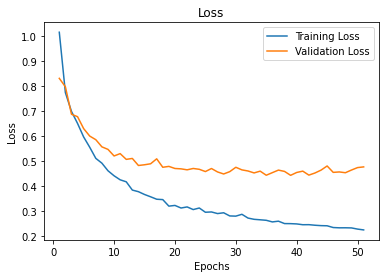

In [15]:
epochs = []
for i in range(1, num_epochs+1):
    epochs.append(i)
import matplotlib.pyplot as plt
%matplotlib inline
# if logger_prefix == 'val':
plot1 = plt.plot(epochs, train_loss)
# else:
plot2 = plt.plot(epochs, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend(["Training Loss", "Validation Loss"], loc = 1)
plt.show()

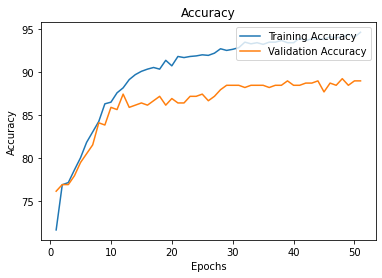

In [16]:
epochs = []
for i in range(1, len(train_accuracy)+1):
    epochs.append(i)
plot3 = plt.plot(epochs, train_accuracy)
plot4 = plt.plot(epochs, val_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"], loc = 1)
plt.show()

In [17]:

# Use your best model to generate results on test set.

# generate csv file for test set
def predict_on_test(model, data_loader):
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open("results.csv",'w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        scores = model(input_sequence_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i])+'\n')
            count+=1
    results.close()
    return count

count = predict_on_test(model, valLD)
print(count)


390


use cuda: True
/content/cloned-repo/mi_seminar_uebung/mi_seminar_uebung/./tmp//lukas_f_squat_1.mp4_rotated.avi
/content/cloned-repo/mi_seminar_uebung/mi_seminar_uebung/data_aufnahme_json/lukas_f_squat_1.mp4_rotated_json/lukas_f_squat_1.mp4_rotated.avi.avi


TypeError: ignored

## Detect poses on a test video

We are going to detect poses on the following youtube video:

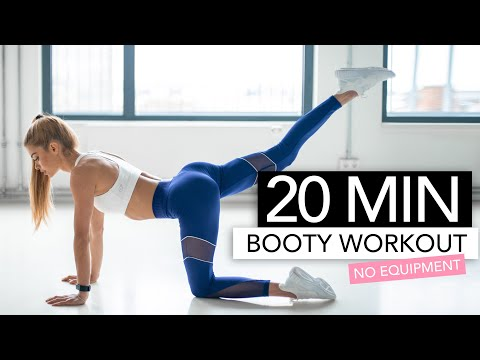

In [34]:
from IPython.display import YouTubeVideo
YOUTUBE_ID = 'HeolReSa5ic'


YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, remove the first 15 seconds and do the pose detection on the next 5 seconds:

In [36]:
!rm -rf ./temp/youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "./temp/youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the seconds between 15 and 20
!ffmpeg -y -loglevel info  -i ./temp/youtube.mp4 -ss 00:12:10 -t 00:12:12 -c:v copy -c:a copy ./temp/video.mp4
# detect poses on the these 5 seconds


[youtube] HeolReSa5ic: Downloading webpage
[download] Destination: ./temp/youtube.mp4
[download] 100% of 72.67MiB in 00:01
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-lib

In [38]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('./temp/youtube.mp4', width=960, height=720)


In [ ]:

!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ~/temp/video.mp4 --write_json ~/output/ --display 0 --write_video ~/openpose.avi --face --hand
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

In [ ]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
from extract_features import create_json_and_mp4
from helper import ReadFromVideo, VideoWriter, ImageDisplayer, draw_scores_onto_image
from preprocessing import preapareDataOfFolder


class Dataset(DD.Dataset):
    # subset can be: 'train', 'val', 'test'
    def __init__(self, data):
        super(Dataset, self).__init__()

        self.data = np.array(data)
        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        return seq

    def __len__(self):
        return self.num_sequences


num_class = 4


class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()  # read in N, C, H, W
        return x.view(N, -1)


import torchvision.models.inception as inception


class SequenceClassify(nn.Module):
    def __init__(self, dim, batch_size):
        super(SequenceClassify, self).__init__()
        self.convolution = nn.Sequential(
            nn.Conv2d(1, dim, kernel_size=(3, 5), stride=(1, 1)),
            nn.MaxPool2d(2, stride=2),
            nn.LeakyReLU(negative_slope=0.4),
            nn.BatchNorm2d(dim),
            inception.InceptionA(dim, 75),
            nn.Conv2d(299, 75, stride=1, kernel_size=2),
            nn.MaxPool2d(kernel_size=2),
            nn.LeakyReLU(negative_slope=0.3),
            nn.BatchNorm2d(75),
            inception.InceptionA(75, 20),
            Flatten(),
            nn.Linear(int(21960 / (5)), batch_size)
        )
        self.recurrent_layer = nn.LSTM(45, 256, 1)
        self.project_layer = nn.Linear(256, num_class)
        ###################################################


    def forward(self, input1, h_t_1=None, c_t_1=None):
        lstm_input = input1
        rnn_outputs, (hn, cn) = self.recurrent_layer(lstm_input)
        logits = self.project_layer(rnn_outputs[:, -1])
        return logits


PATH = "./model.pth"

use_cuda = torch.cuda.is_available()
# use_cuda = False
print('use cuda: %s' % (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

batch_size = 15
dim = 675
model = SequenceClassify(dim, batch_size)
if use_cuda:
    model.cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

filename = 'lukas_f_squat_1.mp4_rotated.avi'
path = './tmp/'
mp4_file, json_folder = create_json_and_mp4(filename, path)
name_labels = []
labels = []
label_list = ['squat', 'pushup', 'simple', 'jumping']
name_label_list = []
result = []
name_labels, labels, label_list, name_label_list, result = preapareDataOfFolder(json_folder, name_labels, labels,
                                                                                label_list, name_label_list, result)

dataset = Dataset(result)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

images_loader = ReadFromVideo(mp4_file)
img_displayer = ImageDisplayer()

DST_FOLDER = './tmp/created/'
DST_VIDEO_NAME = filename
DST_VIDEO_FPS = images_loader.get_fps()

video_writer = VideoWriter(DST_FOLDER + DST_VIDEO_NAME, DST_VIDEO_FPS)

all_scores = []
for batch_idx, sample in enumerate(data_loader):
    input_sequence_var = Variable(sample).type(FloatTensor)
    scores = model(input_sequence_var)
    sm = torch.nn.Softmax(dim=1)
    probabilities = sm(scores)
    all_scores.append(probabilities)

try:
    ith_img = -1
    while images_loader.has_image():
        # -- Read image
        img = images_loader.read_image()
        ith_img += 1
        img_disp = img.copy()
        print(f"\nProcessing {ith_img}th image ...")
        draw_scores_onto_image(img_disp, all_scores[int(ith_img / (DST_VIDEO_FPS * batch_size))][
            int(ith_img / DST_VIDEO_FPS) % 15],
                               label_list)

        # -- Display image, and write to video.avi
        img_displayer.display(img_disp, wait_key_ms=1)
        video_writer.write(img_disp)

finally:
    video_writer.stop()
    print("Program ends")

Finally, visualize the result:

In [ ]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)